In [1]:
import os
import sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"
sys.path.append('/global/home/users/mgrinberg/parametrized-classifiers/data')
# sys.path.append('/Users/matangrinberg/Library/CloudStorage/GoogleDrive-matan.grinberg@gmail.com/My Drive/(21-24) University of California, Berkeley/ML HEP/parametrized-classifiers/data')

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

import keras

# standard numerical library imports
import numpy as np
import scipy as sp
import tensorflow as tf
import keras

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

from keras.layers import Input, Flatten, Dense
from keras.initializers import Constant
from keras.backend import ones_like, zeros_like, concatenate

import matplotlib.pyplot as plt

In [3]:
# # Global plot settings
# from matplotlib import rc
# import matplotlib.font_manager
# rc('font', family='serif')
# rc('text', usetex=True)
# rc('font', size=22) 
# rc('xtick', labelsize=15) 
# rc('ytick', labelsize=15) 
# rc('legend', fontsize=15)

# Load Data

## Utilities

In [4]:
# normalize pT and center (y, phi)
def normalize(x):
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

In [5]:
def preprocess_data(X):
    for x in X:
        normalize(x)
    
    # Remap PIDs to unique values in range [0,1]
    remap_pids(X, pid_i=3, error_on_unknown=False)
    return X

## Process data

In [6]:
# Path to downloaded data from Zenodo
data_dir = '/global/home/users/mgrinberg/parametrized-classifiers/data/'

In [7]:
dataset = np.load(data_dir + '1D_probStoUD_train.npz')

In [8]:
X = dataset['X']
Y = dataset['Y']

In [9]:
X = preprocess_data(X)
Y = to_categorical(Y, num_classes=2)

In [10]:
X_train, X_val, Y_train, Y_val = data_split(X, Y, test=0.1, shuffle=True)

In [11]:
print(X_train.shape)
print(Y_train.shape)

print(X_val.shape)
print(Y_val.shape)

(1620000, 51, 7)
(1620000, 2)
(180000, 51, 7)
(180000, 2)


# Build Model

In [12]:
# network architecture parameters
Phi_sizes = (100,100, 128)
F_sizes = (100,100, 100)

model_interpolate = PFN(input_dim=7, Phi_sizes=Phi_sizes, F_sizes=F_sizes, summary=False)

# Train model

In [13]:
save_label = 'DCTR_ee_dijets_1D_probStoUD'


checkpoint = keras.callbacks.ModelCheckpoint('./saved_models/' + save_label + '.h5', monitor='val_loss', verbose=2, save_best_only=True, mode='min')
CSVLogger = keras.callbacks.CSVLogger('./logs/' + save_label + '_loss.csv', append=False)
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)
callbacks = [checkpoint, CSVLogger, EarlyStopping]

epochs = 100
batch_size = 2000

In [14]:
history = model_interpolate.fit(X_train, Y_train,
                    epochs = epochs,
                    batch_size = batch_size,
                    validation_data = (X_val, Y_val),
                    verbose = 1, 
                    callbacks = callbacks)

Epoch 1/100
802/810 [============================>.] - ETA: 0s - loss: 0.7145 - acc: 0.5042
Epoch 1: val_loss improved from inf to 0.69462, saving model to ./saved_models/DCTR_ee_dijets_1D_probStoUD.h5
810/810 [==============================] - 7s 7ms/step - loss: 0.7143 - acc: 0.5042 - val_loss: 0.6946 - val_acc: 0.5071
Epoch 2/100
802/810 [============================>.] - ETA: 0s - loss: 0.6939 - acc: 0.5098
Epoch 2: val_loss improved from 0.69462 to 0.69362, saving model to ./saved_models/DCTR_ee_dijets_1D_probStoUD.h5
810/810 [==============================] - 5s 6ms/step - loss: 0.6939 - acc: 0.5098 - val_loss: 0.6936 - val_acc: 0.5133
Epoch 3/100
804/810 [============================>.] - ETA: 0s - loss: 0.6926 - acc: 0.5144
Epoch 3: val_loss improved from 0.69362 to 0.69317, saving model to ./saved_models/DCTR_ee_dijets_1D_probStoUD.h5
810/810 [==============================] - 5s 6ms/step - loss: 0.6926 - acc: 0.5144 - val_loss: 0.6932 - val_acc: 0.5141
Epoch 4/100
810/810 [==

# Plot History

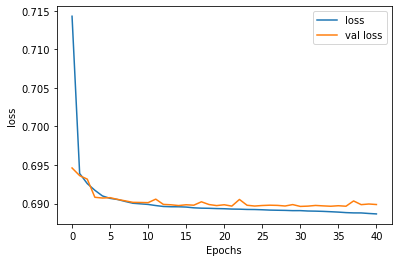

In [15]:
plt.plot(history.history['loss'],     label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend(loc=0)
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.show()

# Load Model

In [16]:
# load model from saved file
dctr.model.load_weights('./saved_models/DCTR_ee_dijets_1D_probStoUD.h5')

# Fitting

## Loss Curve Model

In [16]:
def model_parameter_finder(model_interpolate, X_dim, n_params, default_params, trainable_params):
    """ 
    Get a model that trains on the input parameters
    
    Arguments:
    - model_interpolate : a PFN model that has been trained to continuously interpolate over the input parameter dimensions
    - X_dim : (int) - the dimension of the input expected by DCTR_model
    - n_params : (int) - the number of n_params that are in X_dim
    - default_params : (list of floats) - default values for each of the parameters
    - trainable_params : (list of booleans) - True for parameters that you want to fit, false for parameters that should be fixed at default value

    Returns:
    - model_parameter_finder: a compiled model that gradient descends only on the trainable parameters
    """
    
    # Do sanity checks on inputs
    assert X_dim >=n_params, "X_dim must be larger than n_params. X_dim includes the dimensionality of the 4-vector + number of parameters"
    assert n_params == len(default_params), "Dimension mismatch between n_params and number of default parameters given. len(default_params) must equal n_params"
    assert n_params == len(trainable_params), "Dimension mismatch between n_params and trainable_params. len(trainable_params) must equal n_params."
    assert np.any(trainable_params), "All parameters are set to non-trainable."
    
    # Convert input parameters to weights and make then trainable or non-trainable
    p_models = []
    for i in range(n_params):
        p_models.append(Dense(1, use_bias=False, kernel_initializer=Constant(default_params[i]), trainable=trainable_params[i], name='tuning_param_{}'.format(i)))

    parameter_inputs = keras.Input(shape=(None, 4), name='mp_input')
    # parameter_models =  keras.layers.concatenate([p_models[0](parameter_inputs), p_models[1](parameter_inputs), p_models[2](parameter_inputs)])
    # model_parameters = keras.Model(inputs = parameter_inputs, outputs = parameter_models)
    ones = tf.ones_like(parameter_inputs[:,:,0:1])
    full_input =  keras.layers.concatenate([parameter_inputs, p_models[0](ones), p_models[1](ones), p_models[2](ones)])
    model_inputs = keras.Model(inputs = parameter_inputs, outputs = full_input)

    # Set all weights in interpolation_model to non-trainable
    for l in model_interpolate.layers: 
        l.trainable = False

    # Define input to DCTR_fit_model
    raw_inputs = keras.Input(shape=(None, X_dim - n_params), name='pf_input')
    inputs = model_inputs(raw_inputs)
    output = model_interpolate.model(inputs)

    # Define full model
    model_parameter_finder = keras.Model(inputs = raw_inputs, outputs = output, name='pf_output')
    optimizer = keras.optimizers.Adam(learning_rate=1e-4)
    loss = keras.losses.CategoricalCrossentropy()

    # Compile with loss function
    model_parameter_finder.compile(optimizer=optimizer, loss=loss)
    
    return model_parameter_finder

In [17]:
def set_params(model_parameter_finder, params, param_layer=1):
    alphaS, aLund, StoUD = params
    weights = [np.array([[alphaS]], dtype=np.float32), np.array([[aLund]], dtype=np.float32), np.array([[StoUD]], dtype=np.float32)]
    model_parameter_finder.layers[param_layer].set_weights(weights)
    # print(model_parameter_finder.layers[param_layer].get_weights())
    
def get_loss(X, Y, model_parameter_finder, params, batch_size=1000, param_layer=1):
    set_params(model_parameter_finder, params, param_layer)
    return model_parameter_finder.evaluate(x=X, y=Y, batch_size=batch_size)

In [18]:
model_pf = model_parameter_finder(model_interpolate, X_dim =7, n_params = 3, 
                                    default_params   = [0.1365, 0.68, 0.217], # default params for [alpha_s, aLund, StoUD]
                                    trainable_params = [False, False, True]) # Only train StoUD

In [19]:
model_pf = model_parameter_finder(model_interpolate, X_dim =7, n_params = 3, 
                               default_params   = [0.1365, 0.68, 0.217], # default params for [alpha_s, aLund, StoUD]
                               trainable_params = [False, True, False]) # Only train aLund

model_pf.summary()

Model: "pf_output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pf_input (InputLayer)       [(None, None, 4)]         0         
                                                                 
 model_2 (Functional)        (None, None, 7)           3         
                                                                 
 model (Functional)          (None, 2)                 57130     
                                                                 
Total params: 57,133
Trainable params: 1
Non-trainable params: 57,132
_________________________________________________________________


In [20]:
print(model_pf.trainable_weights)
keras.utils.plot_model(model_pf, "my_second_model_with_shape_info.png", show_shapes=True)

[<tf.Variable 'tuning_param_1/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.68]], dtype=float32)>]
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## Load Data

In [22]:
default_dataset = np.load(data_dir + 'test1D_default.npz')
unknown_dataset = np.load(data_dir + 'test1D_probStoUD.npz')

In [23]:
X_default = preprocess_data(default_dataset['jet'][:,:,:4])
X_unknown = preprocess_data(unknown_dataset['jet'][:,:,:4])

Y_default = np.zeros_like(X_unknown[:,0,0])
Y_unknown = np.ones_like(X_unknown[:,0,0])

In [24]:
X_fit = np.concatenate((X_default, X_unknown), axis = 0)
Y_fit = np.concatenate((Y_default, Y_unknown), axis = 0)
Y_fit = to_categorical(Y_fit, num_classes=2)

In [25]:
X_fit, _, Y_fit, _ = data_split(X_fit, Y_fit, test=0, shuffle=True)

## Evaluate Loss as a function of MC parameter

In [26]:
n = 10000
X_f=X_fit[0:n]

In [27]:
a1 = [0.1365,0.68,0.217] * tf.ones((n, 51, 3))
a2 = [0.1365,0.68,0.24] * tf.ones((n, 51, 3))
a3 = [0.1365,0.68,0.27] * tf.ones((n, 51, 3))
a4 = [0.1365,0.68,0.3] * tf.ones((n, 51, 3))
b1 = tf.concat([X_f, a1], axis=-1)
b2 = tf.concat([X_f, a2], axis=-1)
b3 = tf.concat([X_f, a3], axis=-1)
b4 = tf.concat([X_f, a4], axis=-1)
preds1 = model_interpolate.model(b1[0:n])
preds2 = model_interpolate.model(b2[0:n])
preds3 = model_interpolate.model(b3[0:n])
preds4 = model_interpolate.model(b4[0:n])
loss = keras.losses.CategoricalCrossentropy()

In [28]:
print(loss(Y_fit[0:n], preds1))
print(loss(Y_fit[0:n], preds2))
print(loss(Y_fit[0:n], preds3))
print(loss(Y_fit[0:n], preds4))

tf.Tensor(0.6923539, shape=(), dtype=float32)
tf.Tensor(0.691508, shape=(), dtype=float32)
tf.Tensor(0.6922504, shape=(), dtype=float32)
tf.Tensor(0.6939798, shape=(), dtype=float32)


In [29]:
print(get_loss(X_fit, Y_fit, model_pf, [0.1365, 0.6, 0.217]))
print(get_loss(X_fit, Y_fit, model_pf, [0.1365, 0.7, 0.217]))
print(get_loss(X_fit, Y_fit, model_pf, [0.1365, 0.8, 0.217]))
print(get_loss(X_fit, Y_fit, model_pf, [0.1365, 0.9, 0.217]))

1800/1800 [==============================] - 4s 2ms/step - loss: 0.6916
0.6915905475616455
1800/1800 [==============================] - 4s 2ms/step - loss: 0.6926
0.6926363110542297
1800/1800 [==============================] - 4s 2ms/step - loss: 0.6951
0.6950533390045166
1800/1800 [==============================] - 4s 2ms/step - loss: 0.6992
0.6991843581199646


In [31]:
probStoUD_loss = np.array([(p, get_loss(X_fit, Y_fit, model_pf, [0.1365, 0.68, p])) for p in np.linspace(0.2,0.3, 31)])


1800/1800 [==============================] - 4s 2ms/step - loss: 0.6931


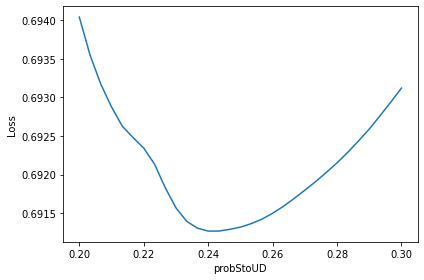

In [34]:
plt.plot(*probStoUD_loss.T)
plt.ylabel('Loss')
plt.xlabel(r'probStoUD')
plt.tight_layout()
plt.show()

In [35]:
def get_min_loss(losses, x0):
    f = sp.interpolate.interp1d(losses[:,0], losses[:,1], fill_value="extrapolate")
    return sp.optimize.minimize(f, x0=x0)['x']

get_min_loss(probStoUD_loss, x0=0.217)

array([0.24])

## Tune with Gradient Descent

In [46]:
set_MC_params(dctr_fit_model, [0.217, 0.1365, 0.68])

In [47]:
print_weights = keras.callbacks.LambdaCallback(on_epoch_end=lambda batch, logs: print("probStoUD fit = ", 
                                               dctr_fit_model.get_weights()[0][0][0]))
fit_vals = [0.217]
append_weights = keras.callbacks.LambdaCallback(on_epoch_end=lambda batch, logs: 
                                               fit_vals.append(dctr_fit_model.get_weights()[0][0][0]))

callbacks = [print_weights, append_weights]

In [48]:
dctr_fit_model.fit(X_fit, Y_fit,
                   epochs=20, 
                   batch_size=10000,
                   callbacks = callbacks)

Epoch 1/20
1800000/1800000 [==============================] - 9s 5us/step - loss: 0.6919
probStoUD fit =  0.23250206
Epoch 2/20
1800000/1800000 [==============================] - 9s 5us/step - loss: 0.6912
probStoUD fit =  0.24520627
Epoch 3/20
1800000/1800000 [==============================] - 9s 5us/step - loss: 0.6908
probStoUD fit =  0.25438046
Epoch 4/20
1800000/1800000 [==============================] - 9s 5us/step - loss: 0.6907
probStoUD fit =  0.26044643
Epoch 5/20
1800000/1800000 [==============================] - 9s 5us/step - loss: 0.6906
probStoUD fit =  0.26435077
Epoch 6/20
1800000/1800000 [==============================] - 9s 5us/step - loss: 0.6906
probStoUD fit =  0.26648346
Epoch 7/20
1800000/1800000 [==============================] - 9s 5us/step - loss: 0.6906
probStoUD fit =  0.2679642
Epoch 8/20
1800000/1800000 [==============================] - 9s 5us/step - loss: 0.6906
probStoUD fit =  0.2687535
Epoch 9/20
1800000/1800000 [==============================] - 9s 5

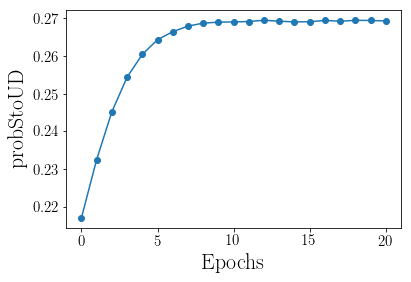

In [49]:
plt.plot(fit_vals, marker='o')
plt.xlabel("Epochs")
plt.ylabel(r'probStoUD')
plt.show()